In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

from class_new import *
import class_new
import importlib
importlib.reload(class_new)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, UpSampling2D, Input, Convolution2D, Reshape
from tensorflow.keras.optimizers import Adam

known_volume_path = 'E:\\spcup2022\\spcup_2022_training_part1'
unknown_volume_path = 'E:\\spcup2022\\spcup_2022_unseen_data'

rs = 10
known_path, known_labels = file_path_list(known_volume_path)
unknown_path, unknown_labels = file_path_list(unknown_volume_path)
#known_path, known_labels = part2_file_path_list(known_volume_path, label=True)
#unknown_path, unknown_labels = part2_file_path_list(unknown_volume_path, label=False)

print(len(known_path), known_labels.shape)
print(len(unknown_path), unknown_labels.shape)

all_path = np.concatenate((known_path, unknown_path), axis=0)
all_labels = np.concatenate((known_labels, unknown_labels), axis=0)
print(all_path.shape, all_labels.shape)

In [ ]:
X_train_path, X_test_path, y_train_raw, y_test_raw = train_test_split(all_path, all_labels, test_size=0.2, stratify=all_labels, random_state=rs)

n_mels = 64
samplint_rate = 16000

train = data(X_train_path, y_train_raw, n_mels=n_mels, known=True)
test = data(X_test_path, y_test_raw, n_mels=n_mels, known=True)

print('extract_mel ...')
train.extract_mel()
test.extract_mel()

print('reshape_data ...')
train.reshape_data()
test.reshape_data()

X_train = train.X_reshaped
X_test = test.X_reshaped
y_train = train.y_reshaped
y_test = test.y_reshaped

np.save("x_train_to_mel_" + str(X_train.shape[0]), X_train)
np.save("x_test_to_mel_" + str(X_test.shape[0]), X_test)
np.save("y_train_to_mel_" + str(y_train.shape[0]), y_train)
np.save("y_test_to_mel_" + str(y_test.shape[0]), y_test)

print('save finished')

In [ ]:
for n_mels in [128]:
    for hop_length in [512]:
        for n_fft in [2048]:
            from tensorflow.keras.models import Sequential
            from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D
            from tensorflow.keras.callbacks import EarlyStopping
            from tensorflow.keras.callbacks import ModelCheckpoint

            print((X_train.shape[1:]))
            
            
            # model 1
            model = Sequential()
            model.add(layers.BatchNormalization(input_shape=(X_train.shape[1:])))
            model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation='relu'))
            model.add(MaxPool2D(pool_size=(5, 5)))
            model.add(Flatten())
            model.add(layers.Dense(6, activation=None))
            model.add(layers.Activation('softmax'))
            model.summary()
            
            '''
            # model 2
            model = Sequential()
            model.add(layers.BatchNormalization(input_shape=(X_train.shape[1:])))
            model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu'))
            model.add(MaxPool2D(pool_size=(3, 3)))
            model.add(Flatten())
            model.add(layers.Dense(6, activation=None))
            model.add(layers.Activation('softmax'))
            model.summary()
            '''
            
            # callback 설정
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='auto', restore_best_weights=True)
            best_weight = str(rs) + "_" + str(n_mels) + "_" + str(hop_length) +"_" + str(n_fft) + "_" + "bestmodel.h5"
            checkpointer = ModelCheckpoint(monitor='val_loss', filepath=best_weight, verbose=1, save_best_only=True, save_weights_only=True)
            
            # 모델 컴파일
            model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
            classifier = model.fit(X_train, y_train, epochs=1000, batch_size=128, callbacks=[early_stopping, checkpointer], validation_split=0.2)

#             model_json = model.to_json()
#             with open("./models_log" + "/" + str(rs) + "_" + "spcup.json", 'w') as json_file:
#                 json_file.write(model_json)
            #             model.save_weights("./models_log" + "/" + str(rs) + "_" + "spcup.h5")
            print("Saved model to disk")


            #             #### json 모델 load
            #             from keras.models import model_from_json
            #             json_file = open("model.json", "r")
            #             loaded_model_json = json_file.read()
            #             json_file.close()
            #             loaded_model = model_from_json(loaded_model_json)

plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
# plt.plot(classifier.history['loss'])
# plt.plot(classifier.history['val_loss'])
plt.legend(['accuracy','val_accuracy'], loc = 'upper left')
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('테스트 정확도:', test_acc)

prediction = model.predict(X_test)

In [ ]:
# 전이학습
model.load_weights(str(rs) + "_" + str(n_mels) + "_" + str(hop_length) +"_" + str(n_fft) + "_" + "bestmodel.h5")

early_stopping_transfer = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='auto', restore_best_weights=True)
best_weight_transfer = str(rs) + "_" + str(n_mels) + "_" + str(hop_length) +"_" + str(n_fft) + "_" + "bestmodel_transfer.h5"
checkpointer_transfer = ModelCheckpoint(monitor='val_loss', filepath=best_weight_transfer, verbose=1, save_best_only=True, save_weights_only=True)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
classifier = model.fit(X_train, y_train, epochs=1000, batch_size=128, callbacks=[early_stopping_transfer, checkpointer_transfer], validation_split=0.2)

model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
classifier = model.fit(X_train, y_train, epochs=1000, batch_size=128, callbacks=[early_stopping_transfer, checkpointer_transfer], validation_split=0.2)

plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
# plt.plot(classifier.history['loss'])
# plt.plot(classifier.history['val_loss'])
plt.legend(['accuracy','val_accuracy'], loc = 'upper left')
plt.show()

test_loss_transer, test_acc_transer = model.evaluate(X_test,  y_test, verbose=2)
print('테스트 정확도:', test_acc_transer)

prediction_transer = model.predict(X_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 64, 32, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 32, 16)        416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 32, 32)        12832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 32, 64)        51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 6, 64)         0

Using TensorFlow backend.


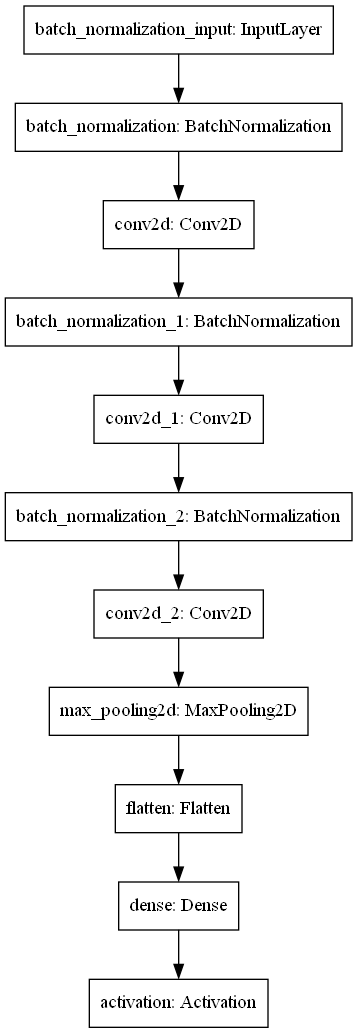

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf

model = Sequential()
model.add(layers.BatchNormalization(input_shape=(64, 32, 1)))
model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation='relu'))
model.add(MaxPool2D(pool_size=(5, 5)))
model.add(Flatten())
model.add(layers.Dense(6, activation=None))
model.add(layers.Activation('softmax'))
model.summary()

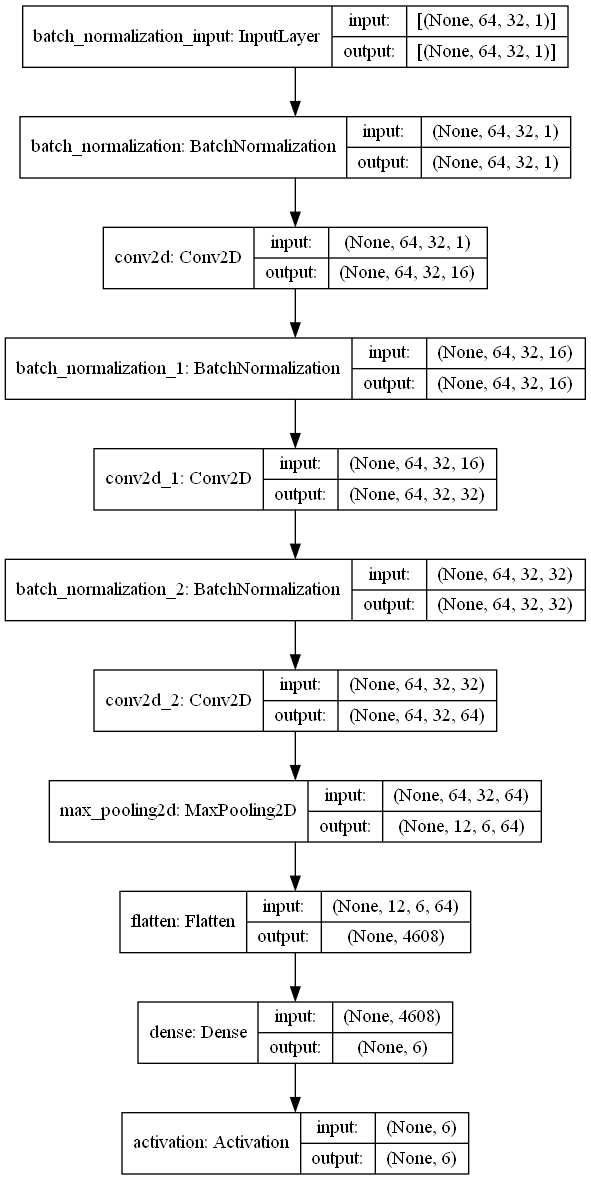

In [2]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)